# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

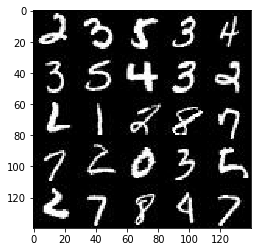

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

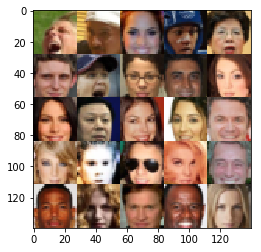

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, (None,image_width,image_height,image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input 28x28x1
        x1 = tf.layers.conv2d(images,64,5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        # flatten it
        flat = tf.reshape(relu2,(-1,7*7*128))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = False if is_train==True else True  
        
    with tf.variable_scope('generator',reuse=not is_train):        
        
        x1 = tf.layers.dense(z,7*7*128)
        x1 = tf.reshape(x1,(-1,7,7,128))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        # 7x7x128
        
        x2 = tf.layers.conv2d_transpose(x1,64,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x64
        
        # output layer
        logits = tf.layers.conv2d_transpose(x2,out_channel_dim,5,strides=2,padding='same')
        # 28x28x1
        
        out = tf.tanh(logits)
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # get w and b to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, _ = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):                
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                # Print the loss every 10 steps:                
                if steps % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # Show images every 100 steps               
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.5288... Generator Loss: 0.0656
Epoch 1/2... Discriminator Loss: 0.8582... Generator Loss: 2.1448
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.5552
Epoch 1/2... Discriminator Loss: 0.2536... Generator Loss: 2.3439
Epoch 1/2... Discriminator Loss: 0.0799... Generator Loss: 3.1914


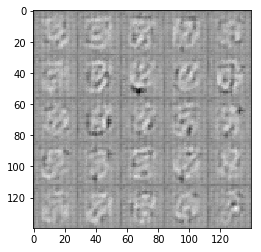

Epoch 1/2... Discriminator Loss: 9.5278... Generator Loss: 0.0001
Epoch 1/2... Discriminator Loss: 4.3705... Generator Loss: 0.0175
Epoch 1/2... Discriminator Loss: 0.3159... Generator Loss: 2.3258
Epoch 1/2... Discriminator Loss: 1.6798... Generator Loss: 1.2689
Epoch 1/2... Discriminator Loss: 0.7094... Generator Loss: 1.1723


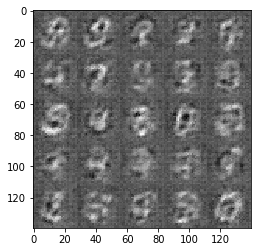

Epoch 1/2... Discriminator Loss: 0.0363... Generator Loss: 4.7613
Epoch 1/2... Discriminator Loss: 0.0970... Generator Loss: 3.0242
Epoch 1/2... Discriminator Loss: 0.1528... Generator Loss: 2.3438
Epoch 1/2... Discriminator Loss: 0.0367... Generator Loss: 4.2051
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 0.7977


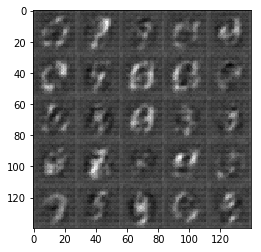

Epoch 1/2... Discriminator Loss: 0.4234... Generator Loss: 1.5835
Epoch 1/2... Discriminator Loss: 0.6465... Generator Loss: 0.9394
Epoch 1/2... Discriminator Loss: 0.3652... Generator Loss: 1.3772
Epoch 1/2... Discriminator Loss: 0.1897... Generator Loss: 2.0976
Epoch 1/2... Discriminator Loss: 0.1056... Generator Loss: 2.8587


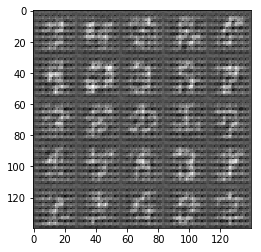

Epoch 1/2... Discriminator Loss: 0.0571... Generator Loss: 3.5546
Epoch 1/2... Discriminator Loss: 0.5241... Generator Loss: 1.7016
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.5217
Epoch 2/2... Discriminator Loss: 0.4502... Generator Loss: 1.8839
Epoch 2/2... Discriminator Loss: 0.7052... Generator Loss: 0.8810


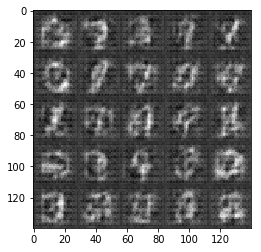

Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 0.9963
Epoch 2/2... Discriminator Loss: 0.1318... Generator Loss: 2.5129
Epoch 2/2... Discriminator Loss: 0.2167... Generator Loss: 1.8867
Epoch 2/2... Discriminator Loss: 0.0770... Generator Loss: 3.1855
Epoch 2/2... Discriminator Loss: 0.0933... Generator Loss: 2.7703


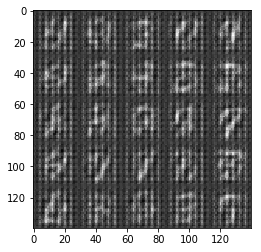

Epoch 2/2... Discriminator Loss: 0.1000... Generator Loss: 2.7808
Epoch 2/2... Discriminator Loss: 0.0425... Generator Loss: 3.6403
Epoch 2/2... Discriminator Loss: 0.1386... Generator Loss: 2.3926
Epoch 2/2... Discriminator Loss: 0.0559... Generator Loss: 3.4344
Epoch 2/2... Discriminator Loss: 0.0283... Generator Loss: 4.0230


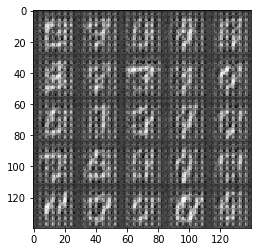

Epoch 2/2... Discriminator Loss: 0.0172... Generator Loss: 4.4979
Epoch 2/2... Discriminator Loss: 0.0096... Generator Loss: 5.9081
Epoch 2/2... Discriminator Loss: 0.0416... Generator Loss: 3.9739
Epoch 2/2... Discriminator Loss: 0.0179... Generator Loss: 6.3681
Epoch 2/2... Discriminator Loss: 0.1207... Generator Loss: 2.6202


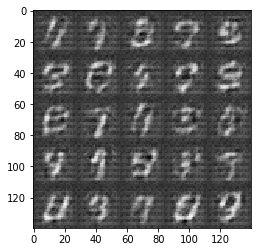

Epoch 2/2... Discriminator Loss: 13.8494... Generator Loss: 0.0000
Epoch 2/2... Discriminator Loss: 0.5983... Generator Loss: 1.7102
Epoch 2/2... Discriminator Loss: 0.4300... Generator Loss: 1.7777
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 3.3306
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 0.9141


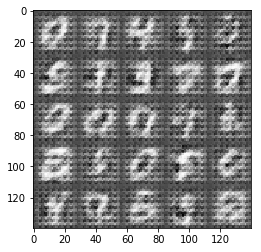

Epoch 2/2... Discriminator Loss: 0.2111... Generator Loss: 3.2533


In [18]:
batch_size = 128
z_dim = 100 # 100 200 500
learning_rate = 0.001 # 0.0001 0.01 0.02 0.002 0.0002 0.00002 0.1 0.0004 0.0006 0.001
beta1 = 0.5 # 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 0.1910... Generator Loss: 4.0623
Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.4349
Epoch 1/1... Discriminator Loss: 0.1394... Generator Loss: 2.6456
Epoch 1/1... Discriminator Loss: 0.4805... Generator Loss: 1.7708


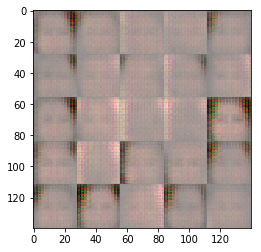

Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 5.5722
Epoch 1/1... Discriminator Loss: 0.2145... Generator Loss: 2.3631
Epoch 1/1... Discriminator Loss: 3.1079... Generator Loss: 5.5208
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.3531
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 4.3660


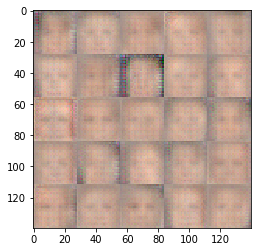

Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 0.0365... Generator Loss: 5.0894
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.5302
Epoch 1/1... Discriminator Loss: 0.5266... Generator Loss: 1.1963


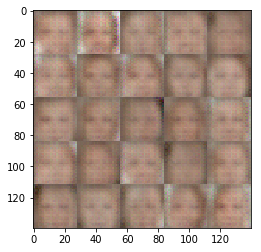

Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.4009... Generator Loss: 2.3639
Epoch 1/1... Discriminator Loss: 0.0223... Generator Loss: 7.0922
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.4526
Epoch 1/1... Discriminator Loss: 0.0693... Generator Loss: 3.1557


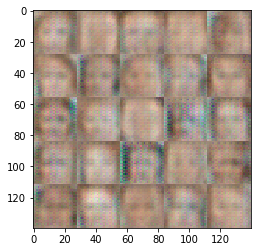

Epoch 1/1... Discriminator Loss: 0.6489... Generator Loss: 3.4266
Epoch 1/1... Discriminator Loss: 0.0168... Generator Loss: 7.2277
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 8.2328
Epoch 1/1... Discriminator Loss: 0.0051... Generator Loss: 5.7606
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.1716


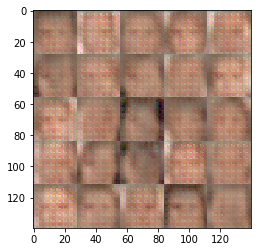

Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.9526
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 1.4048
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.5556


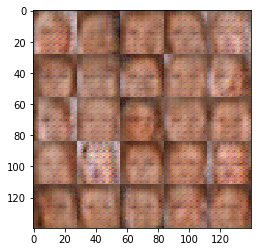

Epoch 1/1... Discriminator Loss: 0.5212... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 1.2645
Epoch 1/1... Discriminator Loss: 0.0374... Generator Loss: 3.8860
Epoch 1/1... Discriminator Loss: 2.9992... Generator Loss: 6.5584
Epoch 1/1... Discriminator Loss: 0.0447... Generator Loss: 3.9219


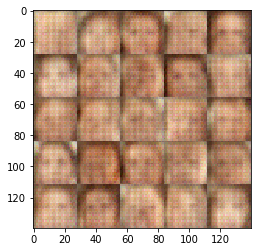

Epoch 1/1... Discriminator Loss: 2.7860... Generator Loss: 0.0798
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 5.1238
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 2.0798
Epoch 1/1... Discriminator Loss: 0.0211... Generator Loss: 5.6118
Epoch 1/1... Discriminator Loss: 3.4020... Generator Loss: 4.7228


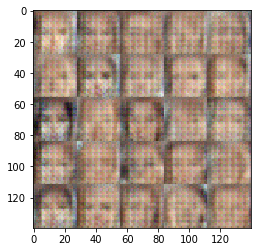

Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.0392
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 0.0086... Generator Loss: 6.0509


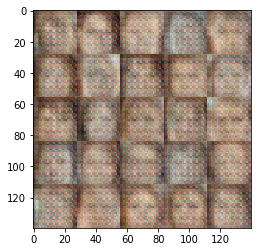

Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.4414
Epoch 1/1... Discriminator Loss: 0.0794... Generator Loss: 3.1689
Epoch 1/1... Discriminator Loss: 0.1012... Generator Loss: 3.2825
Epoch 1/1... Discriminator Loss: 0.6074... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 1.0618


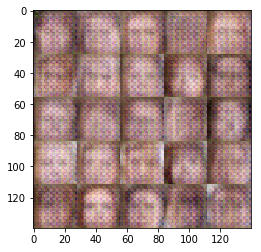

Epoch 1/1... Discriminator Loss: 0.4660... Generator Loss: 1.3459
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.1148
Epoch 1/1... Discriminator Loss: 0.5812... Generator Loss: 1.8064
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 2.9419
Epoch 1/1... Discriminator Loss: 0.0156... Generator Loss: 5.9995


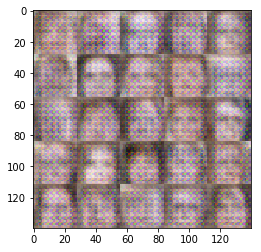

Epoch 1/1... Discriminator Loss: 0.0062... Generator Loss: 5.7975
Epoch 1/1... Discriminator Loss: 0.0328... Generator Loss: 3.6637
Epoch 1/1... Discriminator Loss: 0.0136... Generator Loss: 4.8375
Epoch 1/1... Discriminator Loss: 0.0578... Generator Loss: 3.3016
Epoch 1/1... Discriminator Loss: 0.0271... Generator Loss: 4.0811


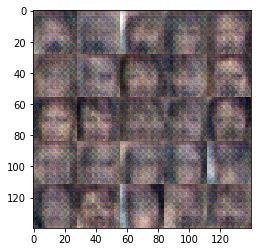

Epoch 1/1... Discriminator Loss: 0.0096... Generator Loss: 5.2867
Epoch 1/1... Discriminator Loss: 0.0213... Generator Loss: 4.1543
Epoch 1/1... Discriminator Loss: 0.0063... Generator Loss: 5.9033
Epoch 1/1... Discriminator Loss: 0.0060... Generator Loss: 5.7631
Epoch 1/1... Discriminator Loss: 0.0085... Generator Loss: 9.6342


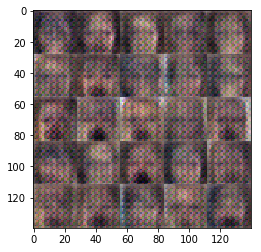

Epoch 1/1... Discriminator Loss: 0.0236... Generator Loss: 3.9694
Epoch 1/1... Discriminator Loss: 1.6884... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 0.6320... Generator Loss: 1.4555
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 2.3025


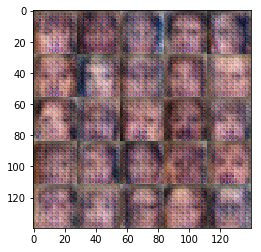

Epoch 1/1... Discriminator Loss: 0.6674... Generator Loss: 1.1908
Epoch 1/1... Discriminator Loss: 0.8616... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 2.3354
Epoch 1/1... Discriminator Loss: 0.8534... Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 2.1267


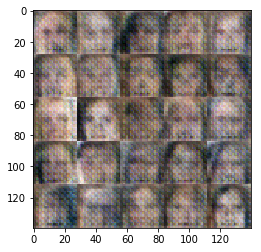

Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.1119... Generator Loss: 1.7443
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 0.6213


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.